# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

from tensorflow.keras import regularizers


%matplotlib inline

RESPONSE_VAR = 'temperature'
WINDOW_SIZE = 7
CONV_WIDTH = 3

In [2]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


In [3]:
df.shape

(45253, 6)

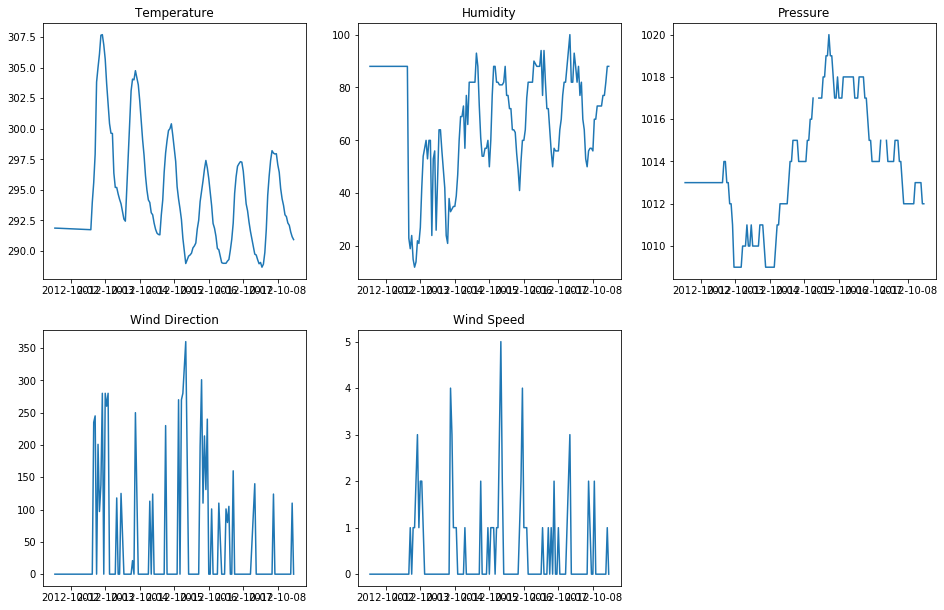

In [4]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [5]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [6]:
252 / df.shape[0]

0.0055686915784588864

In [7]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Feature Engineering
Converting Wind Speed and Direction into X-Y Wind Vectors

In [8]:
# Source: https://www.tensorflow.org/tutorials/structured_data/time_series

wv = df.pop('wind_s')
# Convert to radians.
wd_rad = df.pop('wind_d')*np.pi / 180

# Calculate the wind x and y components.
df['wind_x'] = wv*np.cos(wd_rad)
df['wind_y'] = wv*np.sin(wd_rad)

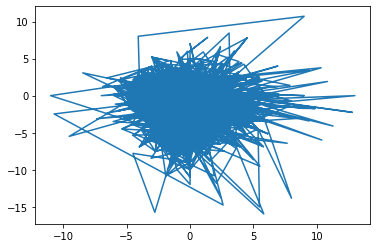

In [9]:
plt.plot(df['wind_x'], df['wind_y'])

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

In [10]:
def remove_seasonality(col, skip_cols, drop=False):
    """skip_cols (list)
    """
    
    if col.name in skip_cols:
        return col
    
    # check if col is stationary, if stationary skip col.
    if stationary_test(col, test=True) is True:
        print(f"Stationary Col: {col}")
        return col
    
    # if column not number, skip col
    if not np.issubdtype(col.dtype, np.number): 
        return col

    if (col < 0).any(): # check if contains neg values
        # add constant, make values positive 
        col = col + col.min()
        
    """Spaghetti Code Alert:
    Can't find a way to invert the np.log(col + 1)
    """
    np.seterr(divide = 'ignore') 
    
    log_values = np.log(col + 1) # add 1 to avoid log(0)
    # bad code: fill NaN with 0
    log_values = np.nan_to_num(log_values)
    
    diff = np.diff(log_values, prepend=np.nan)
    
    if drop: 
        diff = diff.dropna()
    
    return diff

In [11]:
# df = df.apply(remove_seasonality, args=(['datetime'], True))

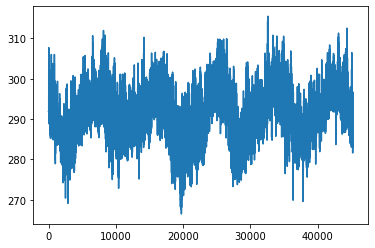

In [12]:
df['temperature'].plot()

In [13]:
# Convert date col to numeric representation.

datetimes = df['datetime']

df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)

## Linear Model

- Q: How does seasonality effect the model? Does this make it possible to compare the MSE? I guess, so after inverse transform... 

In [14]:
train_df, val_df, test_df = split_df(df)
train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, y=None)

In [15]:
train_df

,temperature,humidity,pressure,wind_x,wind_y,Year sin,Year cos
1,0.266932,1.223400,-0.592508,0.094157,0.239792,-1.440727,-0.108952
2,0.266651,1.223400,-0.592508,0.094157,0.239792,-1.440725,-0.107920
3,0.265823,1.223400,-0.592508,0.094157,0.239792,-1.440723,-0.106889
4,0.264996,1.223400,-0.592508,0.094157,0.239792,-1.440719,-0.105858
5,0.264168,1.223400,-0.592508,0.094157,0.239792,-1.440715,-0.104827
...,...,...,...,...,...,...,...
31672,0.105748,0.949324,-0.248199,0.094157,-1.285438,1.019880,-1.050772
31673,0.003459,0.949324,-0.248199,0.094157,-1.285438,1.019225,-1.051553
31674,-0.083333,0.949324,-0.248199,-2.338380,-1.230807,1.018568,-1.052333
31675,-0.163924,0.949324,-0.248199,-0.629889,-1.193456,1.017911,-1.053113


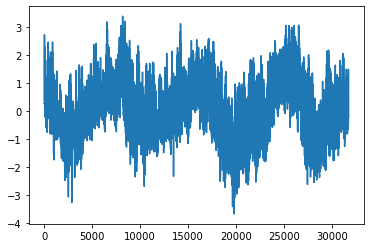

In [16]:
train_df[RESPONSE_VAR].plot()

#### Windowing data

In [17]:
single_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

# window

In [18]:
single_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [19]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, single_window)

# Clear output from Ipython display after compiling.
clear_output()

In [20]:
val_score, test_score = {}, {}

val_score['Linear'] = linear.evaluate(single_window.val)

283/283 [==============================] - 0s 902us/step - loss: 0.0551 - mean_absolute_error: 0.1499 - mean_absolute_percentage_error: 166.4473


In [21]:
test_score['Linear'] = linear.evaluate(single_window.test)

142/142 [==============================] - 0s 1ms/step - loss: 0.0324 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 137.7478


#### Multiple Runs

In [32]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

runs = 5
val_maes, test_maes = [], []
mae_index = 1

for run in range(runs):
    compile_and_fit(linear, single_window);

    # Clear output from Ipython display after compiling.
    clear_output()

    val_maes.append(linear.evaluate(single_window.val)[mae_index])
    test_maes.append(linear.evaluate(single_window.test)[mae_index])

142/142 [==============================] - 0s 834us/step - loss: 0.0335 - mean_absolute_error: 0.1349 - mean_absolute_percentage_error: 140.2398


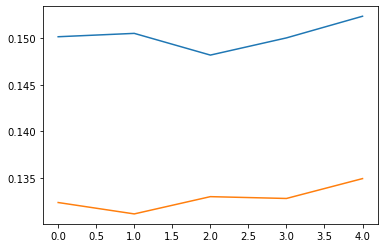

In [34]:
plt.plot(np.arange(0,5), val_maes, test_maes)

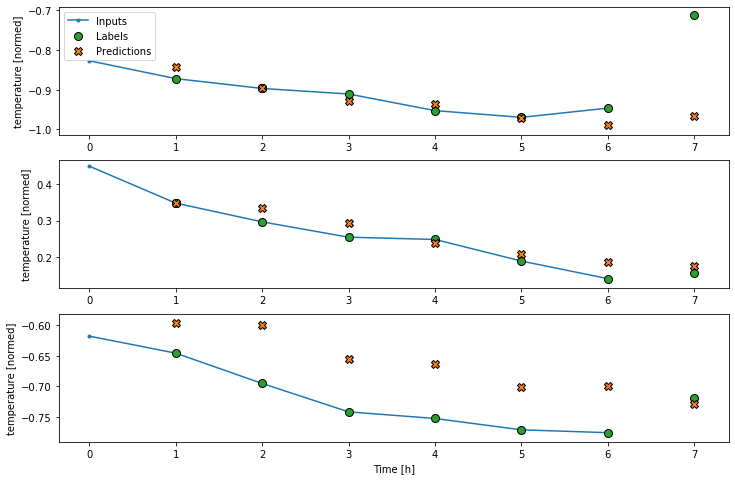

In [23]:
single_window.plot(linear, plot_col=RESPONSE_VAR)

### hmmm... test MAE < val MAE

In [22]:
def rand_slice_indicies(df, sample_size=100):
    """Create a start and end index to be used for 
    Slicing for input df. Limitation as last n-sample_size ... n, will
    be excluded.
    
    Args:
        df (Dataframe): Input dataframe
        sample_size (int): Width of slice range (default 100)
        
    Returns:
        start_index (int): Start of slice
        end_index (int): End of slice
    """
    start_index = np.random.randint(low=0, high=df.shape[0]-sample_size)
    end_index = start_index + sample_size

    return start_index, end_index
    

#### Convolutional Model

In [24]:
CONV_WINDOW_SIZE = WINDOW_SIZE - 2

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


conv_window = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=CONV_WINDOW_SIZE, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

compile_and_fit(conv_model, conv_window)
clear_output()

In [25]:
val_score['Conv'] = conv_model.evaluate(conv_window.val)

283/283 [==============================] - 0s 907us/step - loss: 0.0413 - mean_absolute_error: 0.1185 - mean_absolute_percentage_error: 124.3178


In [26]:
test_score['Conv'] = conv_model.evaluate(conv_window.test)

142/142 [==============================] - 0s 1ms/step - loss: 0.0148 - mean_absolute_error: 0.0835 - mean_absolute_percentage_error: 118.5449


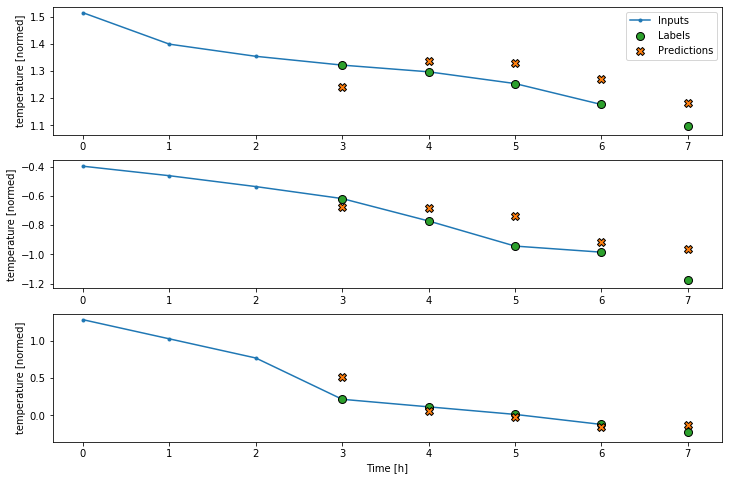

In [27]:
conv_window.plot(conv_model, plot_col=RESPONSE_VAR)

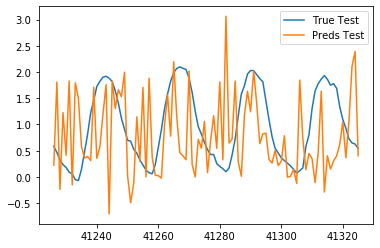

In [44]:
def create_model_preds_df(model, window):
    test_preds = model.predict(window.make_dataset(window.test_df))[:,0,0]
    test_true = window.test_df[RESPONSE_VAR][WINDOW_SIZE:]
    
    test_preds_df = pd.DataFrame({"True Test": test_true,
                                      "Preds Test": test_preds})
    
    return test_preds_df
    
conv_preds_df = create_model_preds_df(conv_model, conv_window)
start_index, end_index = rand_slice_indicies(conv_preds_df)

conv_preds_df[start_index: end_index].plot()

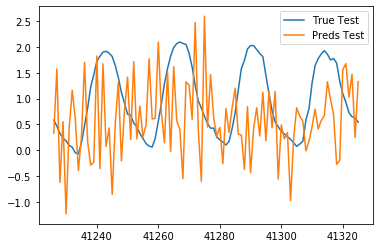

In [52]:
linear_preds_df = create_model_preds_df(linear, single_window)
linear_preds_df[start_index: end_index].plot()

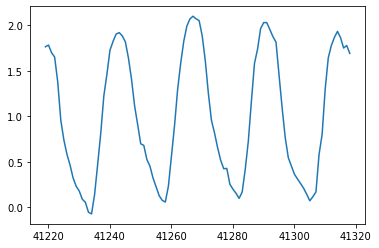

In [50]:
conv_window.test_df['temperature'][start_index:end_index].plot()

In [51]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(conv_preds_df['True Test'], conv_preds_df['Preds Test'])

0.8600399249648332

#### Unsure why MAE is not the same as .evaluate method.

#### Comparing error between train test split and train val test split

Because the Deep Learning models train on 